<a href="https://www.kaggle.com/code/jenntm/gcce-catvsdog-dic-22?scriptVersionId=118201827" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cats vs. Dogs Class dataset for multiple annotators


## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

#import sys
#sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
#sys.path.append('/input/multiple-annotators-c')
#from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

# Multiple annotators model

In [4]:

validation_data = tf.data.experimental.load('/kaggle/input/catsvsdog-ma/cats_dogs_Te')
train_data_MA = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_MA_sin_Tr_1')



2023-02-04 13:36:15.834610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:36:16.035844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:36:16.036691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 13:36:16.038570: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
image_count = tf.data.experimental.cardinality(train_data_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

18610

In [6]:
image_count1 = tf.data.experimental.cardinality(validation_data).numpy() # los datos de training son 18610
image_count1

4652

In [7]:
#X_test = [validation_data[i][0] for i in range(image_count1)]
#Y_true_test = [validation_data[i][1] for i in range(image_count1)]
#Y_true_test = np.asarray([aux[1].numpy() for aux  in validation_data])
#X_test = np.asarray([aux[0].numpy() for aux  in validation_data])

In [8]:
image_count

18610

In [9]:
val_size = int(image_count * 0.2)
train_ds_MA = train_data_MA.skip(val_size)
val_ds_MA = train_data_MA.take(val_size)

In [10]:
batch_size = 100
train_batches_MA = train_ds_MA.shuffle(1024).batch(batch_size)
val_batches_MA = val_ds_MA.shuffle(1024).batch(batch_size)
test_batches_MA = validation_data.shuffle(1024).batch(batch_size)

In [11]:
image_count = tf.data.experimental.cardinality(train_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

14888

In [12]:
image_count_val = tf.data.experimental.cardinality(val_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count_val

3722

2023-02-04 13:36:19.204546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-04 13:36:30.218961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2023-02-04 13:36:33.245625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


annotator 1
              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        55
         1.0       0.75      0.89      0.82        45

    accuracy                           0.82       100
   macro avg       0.82      0.83      0.82       100
weighted avg       0.83      0.82      0.82       100

annotator 2
              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63        55
         1.0       0.54      0.49      0.51        45

    accuracy                           0.58       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.58      0.58      0.58       100

annotator 3
              precision    recall  f1-score   support

         0.0       0.61      0.60      0.61        55
         1.0       0.52      0.53      0.53        45

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57     

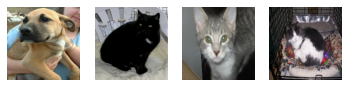

In [13]:
from sklearn.metrics import classification_report
i = 0
fig, ax = plt.subplots(1, 4)
for image, label, label2 in train_batches_MA.take(4):
   # predictedLabel = int(predictions[i] >= 0.5)
   # print(label2)
    ax[i].axis('off')
   # ax[i].set_title(classNames[label[i]])
    ax[i].imshow(image[0])
    i += 1
    for j in range(label2.shape[1]):
      print('annotator',j+1)
      print(classification_report(label ,label2[:,j]))
plt.show()

## Build the classifier from multiple annotators

In [14]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time
from tensorflow.keras import regularizers

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

class MultipleAnnotators_Classification():
    def __init__(self, output_dim, num_annotators, q= 0.0001):
        self.K = output_dim
        self.R = num_annotators
        self.q = q
        #self.callbacks #=callbacks
        #self.l1_param=l1_param 
        #self.l2_param=l1_param

    def CrowdLayer(self, input):
       #x = keras.layers.Dense(self.R + self.K,  ,  activation='tanh')(input)
        output_cla = keras.layers.Dense(self.K,    activation='softmax')(input)
        output_ann = keras.layers.Dense(self.R, activation='sigmoid')(input)
        output = keras.layers.Concatenate()([output_cla, output_ann])
        
        return output
#RCDNN   
#     def loss(self):
#         def custom_loss(y_true, y_pred):
#             # print(y_true,y_pred)
#             pred = y_pred[:, :self.K]
#             pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
#             ann_ = y_pred[:, self.K:]
#             Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
#             Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
#             p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
#             temp1 = ann_*tf.math.log(p_logreg)  
#             temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
#             # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
#             # print(tf.reduce_mean(Y_true,axis=1).numpy())
#             return -tf.math.reduce_sum((temp1 + temp2))
#         return custom_loss
    
    def loss(self):
        def custom_loss(y_true, y_pred):
               # print(y_true,y_pred)
           # q = 0.1
            pred = y_pred[:, :self.K]
            pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
            ann_ = y_pred[:, self.K:]
            # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
            Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
            Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

            p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
            temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
            temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
            return tf.math.reduce_sum((temp1 + temp2))
        return custom_loss

    @tf.function
    def train_step(self, x, Y, y):
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(Y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits[:, :self.K])
        return loss_value

    @tf.function
    def test_step(self, x, y):
        val_logits = self.model(x, training=False)
        self.val_acc_metric.update_state(y, val_logits[:,:self.K])

    def fit(self, model, Data_tr, Data_Val, epochs):
        self.model = model
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate an optimizer.
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
        #self.optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
        #self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, clipnorm=1.0)
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate a loss function.
        self.loss_fn = self.loss()
        self.train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

        train_loss = np.zeros(epochs)
        train_accur = np.zeros(epochs)
        val_accur = np.zeros(epochs)
        val_loss = np.zeros(epochs)

        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train, Y_batch_train) in enumerate(Data_tr):
                # print(y_batch_train, Y_batch_train)
                loss_value = self.train_step(x_batch_train, Y_batch_train, y_batch_train)

                # Log every 200 batches.
                if step % 10 == 0:
                    train_acc = self.train_acc_metric.result()
                    print(
                      "Training loss (for one batch) at step %d: %.4f, Accuracy: %.4f"
                      % (step, float(loss_value), float(train_acc))
                            )
                # print("Seen so far: %d samples" % ((step + 1) * batch_size))



            # Run a validation loop at the end of each epoch.
            for x_batch_val, y_batch_val,Y_batch_val in Data_Val:

                val_logits = model(x_batch_val, training=False)

                val_loss_value = self.loss_fn(Y_batch_val, val_logits)

                self.val_acc_metric.update_state(y_batch_val, val_logits[:,:self.K])
                
               # np.round(np.mean([model(x_batch_val, training= True) for sample in range(100)]), 2)


             # Display metrics at the end of each epoch.
            train_acc = self.train_acc_metric.result()
            val_acc = self.val_acc_metric.result()


            print('---- Training ----')
            print("Training loss: %.4f" % (float(loss_value),))
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            # Reset training metrics at the end of each epoch
            self.train_acc_metric.reset_states()
            self.val_acc_metric.reset_states()


            train_loss[epoch] = float(loss_value)
            train_accur[epoch] = float(train_acc)

            val_accur[epoch] = float(val_acc)
            val_loss[epoch] = float(val_loss_value) 


            print('---- Validation ----')
            print("Validation loss: %.4f" % (float(val_loss_value),))
            print("Validation acc: %.4f" % (float(val_acc),))

            print("Time taken: %.2fs" % (time.time() - start_time))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Loss and accuracy')
        ax1.plot(range(1,epochs+1),train_loss)
        ax1.plot(range(1,epochs+1), val_loss)
        ax2.plot(range(1,epochs+1),train_accur)
        ax2.plot(range(1,epochs+1),val_accur)
        #plt.figure(figsize=(16,9))
        ax1.set(xlabel= 'Epoch', ylabel="Loss")
        ax2.set(xlabel= 'Epoch',ylabel="Accuracy")
        ax1.legend(['Training_loss', 'Validation_loss'])
        ax2.legend(['Training', 'Validation'])
        ax1.grid()
        ax2.grid()
        plt.show()
        return self.model

    def eval_model(self, Data):
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        for x_batch_val, y_batch_val in Data:
            self.test_step(x_batch_val, y_batch_val)

        val_acc = self.val_acc_metric.result()
        self.val_acc_metric.reset_states()
        return val_acc






In [15]:
def custom_loss(y_true, y_pred):
  # print(y_true,y_pred)
  K = 2 #len(np.unique(y_true))
  R = 5
  q = 0.1
  pred = y_pred[:, K]
  pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
  ann_ = y_pred[:,  K:]
  # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
  Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=K, axis=1)
  Y_hat = tf.repeat(tf.expand_dims(pred,-1), R, axis = -1)

  p_gcce = Y_true*(1 - Y_hat**q)/q
  temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
  temp2 = (1 - ann_)*(1-(1/K)**q)/q*tf.reduce_sum(Y_true,axis=1)
  return tf.math.reduce_sum((temp1 + temp2))



In [16]:
MA = MultipleAnnotators_Classification(2, 5, 0.001)
 
def create_model():
   
    l1 = 1e-2
    # Block 1
    inputs = keras.layers.Input(shape=(150, 150, 3), name='entrada')
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu" , name="block1_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)


    # Block 2
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu", name="block2_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block3_conv1" )(x)             
    x = keras.layers.BatchNormalization()(x)
   # x = keras.layers.Dropout(0.2)(x)
   
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
    
    # Block 4
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block4_conv1")(x)            
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    #x = keras.layers.GlobalAveragePooling2D()(x)
   
    x = keras.layers.Flatten()(x)
    #x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = MA.CrowdLayer(x)
    model = keras.Model(inputs=inputs,outputs=output)

    return model
  
  


Start of epoch 0


2023-02-04 13:36:38.977931: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Training loss (for one batch) at step 0: 528.2190, Accuracy: 0.4900
Training loss (for one batch) at step 10: 474.2592, Accuracy: 0.5100
Training loss (for one batch) at step 20: 489.0238, Accuracy: 0.5029
Training loss (for one batch) at step 30: 485.8841, Accuracy: 0.5113
Training loss (for one batch) at step 40: 460.2279, Accuracy: 0.5063
Training loss (for one batch) at step 50: 432.0956, Accuracy: 0.5106
Training loss (for one batch) at step 60: 479.1130, Accuracy: 0.5111
Training loss (for one batch) at step 70: 415.6093, Accuracy: 0.5070
Training loss (for one batch) at step 80: 439.8459, Accuracy: 0.5115
Training loss (for one batch) at step 90: 435.6530, Accuracy: 0.5112
Training loss (for one batch) at step 100: 428.6831, Accuracy: 0.5098
Training loss (for one batch) at step 110: 433.0191, Accuracy: 0.5104
Training loss (for one batch) at step 120: 403.5164, Accuracy: 0.5115
Training loss (for one batch) at step 130: 420.3900, Accuracy: 0.5089
Training loss (for one batch) a

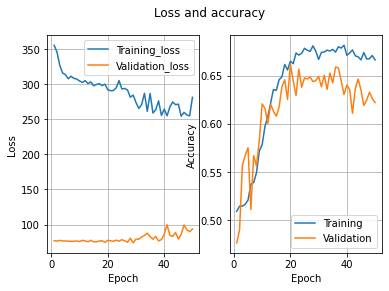

===== Q: 0.0001
Validation acc: 0.6232
Validation AUC: 0.6236
Validation Balanced_ACC: 0.2460
Validation MI: 0.0377
Validation Normalized MI: 0.0548
Validation Adjusted MI: 0.0548

Start of epoch 0
Training loss (for one batch) at step 0: 490.5670, Accuracy: 0.5300
Training loss (for one batch) at step 10: 468.5676, Accuracy: 0.5182
Training loss (for one batch) at step 20: 447.7473, Accuracy: 0.5138
Training loss (for one batch) at step 30: 430.2632, Accuracy: 0.5158
Training loss (for one batch) at step 40: 406.5933, Accuracy: 0.5171
Training loss (for one batch) at step 50: 468.2566, Accuracy: 0.5163
Training loss (for one batch) at step 60: 428.0286, Accuracy: 0.5133
Training loss (for one batch) at step 70: 461.4500, Accuracy: 0.5085
Training loss (for one batch) at step 80: 441.0796, Accuracy: 0.5127
Training loss (for one batch) at step 90: 438.1328, Accuracy: 0.5127
Training loss (for one batch) at step 100: 413.0956, Accuracy: 0.5131
Training loss (for one batch) at step 110: 

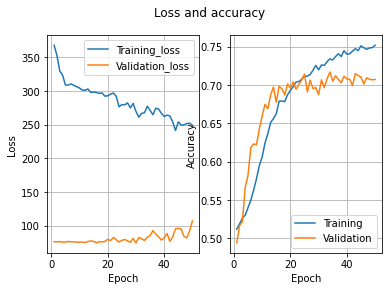

===== Q: 0.0001
Validation acc: 0.6967
Validation AUC: 0.6971
Validation Balanced_ACC: 0.3192
Validation MI: 0.0620
Validation Normalized MI: 0.0900
Validation Adjusted MI: 0.0900

Start of epoch 0
Training loss (for one batch) at step 0: 562.7127, Accuracy: 0.4400
Training loss (for one batch) at step 10: 460.6549, Accuracy: 0.5136
Training loss (for one batch) at step 20: 484.0602, Accuracy: 0.5110
Training loss (for one batch) at step 30: 477.4155, Accuracy: 0.5097
Training loss (for one batch) at step 40: 455.1656, Accuracy: 0.5100
Training loss (for one batch) at step 50: 441.7368, Accuracy: 0.5073
Training loss (for one batch) at step 60: 479.7435, Accuracy: 0.5100
Training loss (for one batch) at step 70: 487.5462, Accuracy: 0.5096
Training loss (for one batch) at step 80: 486.9509, Accuracy: 0.5099
Training loss (for one batch) at step 90: 460.6304, Accuracy: 0.5093
Training loss (for one batch) at step 100: 441.2349, Accuracy: 0.5078
Training loss (for one batch) at step 110: 

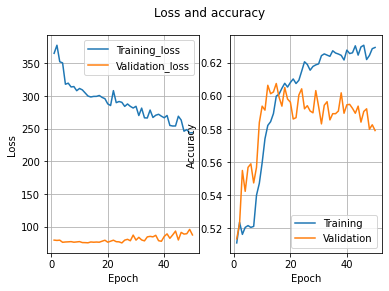

===== Q: 0.0001
Validation acc: 0.5959
Validation AUC: 0.5979
Validation Balanced_ACC: 0.2784
Validation MI: 0.0493
Validation Normalized MI: 0.0718
Validation Adjusted MI: 0.0718

Start of epoch 0
Training loss (for one batch) at step 0: 510.7460, Accuracy: 0.4600
Training loss (for one batch) at step 10: 490.0892, Accuracy: 0.4682
Training loss (for one batch) at step 20: 446.7142, Accuracy: 0.4943
Training loss (for one batch) at step 30: 455.0324, Accuracy: 0.5061
Training loss (for one batch) at step 40: 470.2642, Accuracy: 0.5110
Training loss (for one batch) at step 50: 435.9034, Accuracy: 0.5061
Training loss (for one batch) at step 60: 427.1537, Accuracy: 0.5100
Training loss (for one batch) at step 70: 475.5691, Accuracy: 0.5114
Training loss (for one batch) at step 80: 436.4732, Accuracy: 0.5106
Training loss (for one batch) at step 90: 431.8240, Accuracy: 0.5104
Training loss (for one batch) at step 100: 424.7387, Accuracy: 0.5089
Training loss (for one batch) at step 110: 

2023-02-04 14:09:10.798549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 881 of 1024
2023-02-04 14:09:11.232416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Training loss (for one batch) at step 0: 350.4502, Accuracy: 0.4800
Training loss (for one batch) at step 10: 348.0705, Accuracy: 0.5255
Training loss (for one batch) at step 20: 352.5125, Accuracy: 0.5462
Training loss (for one batch) at step 30: 347.1598, Accuracy: 0.5448
Training loss (for one batch) at step 40: 350.6831, Accuracy: 0.5393
Training loss (for one batch) at step 50: 345.7856, Accuracy: 0.5410
Training loss (for one batch) at step 60: 352.7996, Accuracy: 0.5395
Training loss (for one batch) at step 70: 351.9790, Accuracy: 0.5372
Training loss (for one batch) at step 80: 350.0493, Accuracy: 0.5368
Training loss (for one batch) at step 90: 353.5868, Accuracy: 0.5388
Training loss (for one batch) at step 100: 348.4237, Accuracy: 0.5376
Training loss (for one batch) at step 110: 350.2419, Accuracy: 0.5396
Training loss (for one batch) at step 120: 350.4424, Accuracy: 0.5394
Training loss (for one batch) at step 130: 348.6350, Accuracy: 0.5407
Training loss (for one batch) a

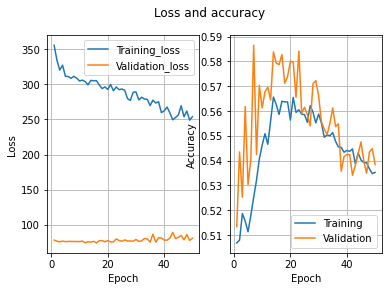

===== Q: 0.0001
Validation acc: 0.5269
Validation AUC: 0.5282
Validation Balanced_ACC: 0.2228
Validation MI: 0.0381
Validation Normalized MI: 0.0555
Validation Adjusted MI: 0.0555

Start of epoch 0


2023-02-04 14:52:59.862148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 628 of 1024
2023-02-04 14:53:01.016213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Training loss (for one batch) at step 0: 506.0920, Accuracy: 0.5100
Training loss (for one batch) at step 10: 484.5080, Accuracy: 0.5200
Training loss (for one batch) at step 20: 510.9998, Accuracy: 0.5267
Training loss (for one batch) at step 30: 486.6156, Accuracy: 0.5190
Training loss (for one batch) at step 40: 474.3538, Accuracy: 0.5117
Training loss (for one batch) at step 50: 496.3777, Accuracy: 0.5157
Training loss (for one batch) at step 60: 471.9480, Accuracy: 0.5138
Training loss (for one batch) at step 70: 437.8120, Accuracy: 0.5161
Training loss (for one batch) at step 80: 477.4695, Accuracy: 0.5163
Training loss (for one batch) at step 90: 463.7956, Accuracy: 0.5188
Training loss (for one batch) at step 100: 465.6212, Accuracy: 0.5173
Training loss (for one batch) at step 110: 478.5704, Accuracy: 0.5158
Training loss (for one batch) at step 120: 443.3830, Accuracy: 0.5166
Training loss (for one batch) at step 130: 450.7891, Accuracy: 0.5162
Training loss (for one batch) a

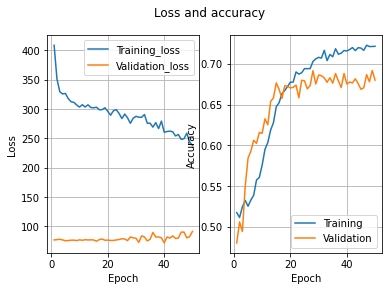

===== Q: 0.0001
Validation acc: 0.6862
Validation AUC: 0.6863
Validation Balanced_ACC: 0.2531
Validation MI: 0.0456
Validation Normalized MI: 0.0664
Validation Adjusted MI: 0.0664


In [17]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
#model = create_model()
K=2
R=5
val_q = [0.0001]   #0.2, 0.4, 0.6, 0.8]
NUM_RUNS = 5
N_EPOCHS = 50 
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
val_acc = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS):
  MA = MultipleAnnotators_Classification(2, 5, val_q[0])
  model =  create_model()
  model = MA.fit(model, train_batches_MA, val_batches_MA, N_EPOCHS)
  #model = MA.fit(model, Data_train_MA, N_EPOCHS)
  ACC[i] = MA.eval_model(test_batches_MA)
  print("===== Q: %.4f" % (float(val_q[0]),))
  print("Validation acc: %.4f" % (float(ACC[i]),))


    #AUC =======================
  val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
  for x_batch_val, y_batch_val in test_batches_MA:
      val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
      val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))   #val_logits[:,Y.shape[1]:].argmax(axis=1).astype('float'))
      BACC1.append(balanced_accuracy_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True))
      MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
      NMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
      AMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))

  val_AUC = val_AUC_metric.result()
  val_AUC_metric.reset_states()
  val_AUC = val_AUC.numpy()
  print("Validation AUC: %.4f" % (float(val_AUC),))
  AUC[i] = val_AUC
  #===================================================
    
  # balanced. Accurcy
  BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
  print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

  #MI
  
  MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation MI: %.4f" % (float(MI[i]),))
  NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
  AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))

    
import pandas as pd
df = pd.DataFrame(ACC)
#df.to_csv('/content/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output

In [18]:
# classification_report_r= []
# model = create_model()
# K=2
# R=5
# NUM_RUNS = 10
# N_EPOCHS = 30
# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(K, R, 0.1)
#   model = create_model()
#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
#   model.compile(optimizer=optimizer, loss= MA.loss())
#   history_model = model.fit(train_batches_MA, validation_data=val_batches_MA, epochs= N_EPOCHS, callbacks=callbacks, verbose=0)
#   #model = MA.fit(model, Data_train_MA, N_EPOCHS)
#   pred_2 = model.predict(X_test)

#   lambda_R_ = pred_2[:, K:] #annotators reliability prediction N x R   
#   classification_report_r += [classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel(),output_dict=True)]
#   print(classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel()))
#   #val_acc[i] = MA.eval_model(test_batches_MA)
#   #print("Validation acc: %.4f" % (float(val_acc[i]),))
#   # Create the history figure
#   plt.figure(figsize=(16,9))
#   for i in  history_model.history:
#       plt.plot(history_model.history[i],label=i)
#   plt.title('Model history')
#   plt.legend()
#   plt.grid()

# import pandas as pd
# df = pd.DataFrame(val_acc)
# #df.to_csimport pandas as pddf = pd.DataFrame(val_acc)#df.to_csv('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output​v('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output


In [19]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  62.580000000000005
Average std:  6.22
Average AUC:  62.660000000000004
Average AUC std:  6.17
Average Balanced Accuracy:  26.39
Average std:  3.2800000000000002
Average MI:  4.66
Average std:  0.89
Average Normalized MI:  6.77
Average std:  1.29
Average Ajdusted MI:  6.77
Average std:  1.29
